In [1]:
import numpy as np
import pandas as pd
#!pip install --user scikit-surprise
from surprise import AlgoBase, PredictionImpossible, Reader, Dataset, accuracy
from surprise.model_selection import train_test_split, cross_validate, GridSearchCV
import time

In [2]:
# Define some helper functions

def clean_df(df):
    '''
    Cleans initial representation to separate rows (users) and columns (movies) into columns with integer values
    '''
    row_str = df["Id"].apply(lambda x: x.split("_")[0])
    row_id = row_str.apply(lambda x: int(x.split("r")[1]) - 1)
    col_str = df["Id"].apply(lambda x: x.split("_")[1])
    col_id = col_str.apply(lambda x: int(x.split("c")[1]) - 1)
    
    data_df = pd.DataFrame(data = {'row': row_id, 'col': col_id, 'Prediction': df.loc[:,'Prediction']})
    
    return data_df


def read_submission_indexes(file_path):
    '''
    Reads the indexes for which to make the predictions.

    Parameters:
    file_path (string): the file path to read

    Returns:
    indexes (list): a list where each element is a tuple of the form (row, column)
    '''

    data_train_raw = pd.read_csv(file_path).values

    tuples = []

    for i in range(data_train_raw.shape[0]):
        indices, value = data_train_raw[i,0], int(data_train_raw[i,1])
        indices = indices.split('_')
        row, column = int(indices[0][1:])-1, int(indices[1][1:])-1 # indexing in the data starts from 1
        tuples.append((row, column))

    return tuples

def write_predictions_to_csv(predictions, file_path):
    '''
    Writes on a csv file the predictions. The format of the prediction file is the following (second row is example):

    Id, Prediction
    r1_c1, 1

    Parameters:
    predictions (surprise.prediction_algorithms.predictions.Prediction): the object holding the predictions
    file_path (string): the path to the prediction file
    '''

    # Define header
    header = []
    header.append('Id')
    header.append('Prediction')

    # Write file
    with open(file_path, 'w') as csvfile:
        writer = csv.writer(csvfile)
        writer = csv.DictWriter(csvfile, fieldnames=header)
        writer.writeheader()
        for row, col, pred in predictions:
            # Row of the csv file
            file_row = {}
            # Build file row
            file_row['Id'] = 'r'+ str(row+1) + '_c' + str(col+1)
            file_row['Prediction'] = pred
            # Write file row
            writer.writerow(file_row)

## Prepare Input

In [3]:
# read data
data_train_raw = pd.read_csv('../data/data-train.csv')
# train dataset as data frame
data_train_df = clean_df(data_train_raw)

In [4]:
# set up surprise dataset
reader = Reader()
dataset = Dataset.load_from_df(data_train_df[['row', 'col', 'Prediction']], reader)

# now set up training and test set, with a test split of 25%
trainset, testset = train_test_split(dataset, test_size=0.25)

In [11]:
def sum_column_norm_square(M):
    """
    Calculate the sum of the squares of column vector norms

    Param:
    ========
    M: np.array, input matrix
    """
    return np.sum(np.square(np.linalg.norm(M, axis = 0)))

def als_objective(A, P, Q, lamb):
    """
    Least squares with regularization
    
    Param:
    ========
    A: np.array, target matrix

    """
    observed_id = np.nonzero(A)
    least_squares = np.sum(np.square(A - P.T@Q)[observed_id]) #extract observed values
    regularization = lamb*(sum_column_norm_square(P)+ sum_column_norm_square(Q))
    error = (least_squares + regularization)/observed_id[0].shape[0]
    return error 

def als(trainset, k, lamb, tol, max_iter):
    """
    Alternating Least Squares algorithm to decompose input trainset into the product of two lower rank matrices, i.e X_train = P^TQ, which P, Q are returned by this function.

    Param:
    ========
    trainset: dataset formatted via surprise dataset
    k: int, rank of lower representation in in vector space 
    lamb: float, regularized factor lambda
    tol: float, error tolerance (used to stop iterations)

    Return:
    ========
    P: np.array, low-rank matrix 
    Q: np.array, low-rank matrix
    """
    m, n = trainset.n_users, trainset.n_items
    # Get rating matrix
    A = np.zeros((m, n))
    for u, i, r in trainset.all_ratings():
        A[u,i] = r
    # Initialize P, Q
    P = np.ones((k,m)) #user matrix
    Q = np.ones((k,n)) #item matrix
    Id_k = np.eye(N=k)
    # Alternate to optimize
    num_iter = 0
    while num_iter < max_iter:
        ls_error = als_objective(A, P, Q, lamb)
        if (num_iter+1) % 10 == 0:
            print("Iter  {}:  error {}".format(num_iter+1, ls_error))
        for u in range(m):
            obs_items = np.nonzero(A[u, :])
            sum_qqT = np.sum([Q[:, i]*np.reshape(Q[:, i], (-1, 1)) for i in obs_items[0]], 0)
            P[:, u] = np.squeeze(np.linalg.inv(sum_qqT+lamb*Id_k) @ np.reshape(np.sum([A[u,item]*Q[:, item] for item in obs_items[0]], 0), (-1, 1)))
        for i in range(n):
            obs_users = np.nonzero(A[:, i])
            sum_ppT = np.sum([P[:, u]*np.reshape(P[:, u], (-1, 1)) for u in obs_users[0]], 0)
            Q[:, i] = np.squeeze(np.linalg.inv(sum_ppT+lamb*Id_k) @ np.reshape(np.sum([A[u, i]*P[:, u] for u in obs_users[0]], 0), (-1, 1)))
        if ls_error <= tol:
            break
        num_iter += 1
    return P, Q

class ALS(AlgoBase):
    """
    Model via Alternating Least Square
    """
    def __init__(self,k, lamb, tol, max_iter):
        self.k = k
        self.lamb = lamb
        self.tol = tol
        self.max_iter = max_iter

    def fit(self, trainset):
        AlgoBase.fit(self, trainset)
        start = time.time()
        self.P, self.Q = als(self.trainset, self.k, self.lamb, self.tol, self.max_iter)
        print("Used time: {}".format(time.time() - start))   

    def estimate(self, u, i):
        return np.clip(np.dot(self.P[:, u], self.Q[:, i]), 1, 5)


## Best Model via Grid Search
Here we presented the best model via grid search on selected hyper-parameters. We stored the best hyper-parameters from experiments.

Grid Search was run on Euler cluster with parallelization. We provide the commented code in the following section "Grid Search" only if you would like to re-run the search again. However, we do not recommend without highly computational power.

In [ ]:
# Best params
k = 5
lamb = 0.9
tol= 0.5
max_iter = 30

# Define the model
model = ALS(k=k, lamb=lamb, tol=tol, max_iter=max_iter)

# Fit the model with trainset
model.fit(trainset)

# Compute the predictions on testset
predictions = model.test(testset)

# Compute RMSE on testset
rmse = accuracy.rmse(predictions)

## Grid Search 

In [13]:
# grid_search_model = GridSearchCV(ALS, param_grid = {"k":[5, 8, 10, 15], "lamb":[0.5, 0.7, 0.9], "max_iter":[5, 10, 30]}, n_jobs = -1)

# grid_search_model.fit(dataset)

# grid_search_model.best_score, model.best_params


## Submission

In [7]:
# Prepare submission indices
pred_ids = read_submission_indexes("../data/sample-submission.csv")


In [12]:
# Best params
k = 5
lamb = 0.9
tol= 0.5
max_iter = 30

model = ALS(k=k, lamb=lamb, tol=tol, max_iter=max_iter)

# Fit on all training data
all_train  = dataset.build_full_trainset()
model.fit(all_train)

Iter  10:  error 0.9151639584930036
Iter  20:  error 0.9107224497156738
Iter  30:  error 0.9094582302046958
Used time: 646.157338142395


In [13]:
# Predictions on Kaggle test data# Predictions on Kaggle test data
submission = []
for r, c in pred_ids:
    submission.append((r, c, model.estimate(r, c)))

In [15]:
import datetime 
import csv
# Save submission predictions
submission_csv = "../predictions/submission_als_{}.csv".format(datetime.datetime.now().strftime('%Y%m%d_%H%M'))

write_predictions_to_csv(submission, submission_csv)

(array([  1682.,   3801.,  11714.,  32422.,  82695., 176866., 282093.,
        299302., 196264.,  90113.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <a list of 10 Patch objects>)

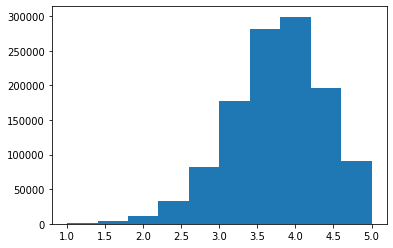

In [17]:
import matplotlib.pyplot as plt
plt.hist([i[2] for i in submission])